In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_data(data):
    '''
    helper function to get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = [t0 + tmp/sampling_rate for tmp in range(0, npoints)]
    
    # station latitude and long
    return t, x, y, z

In [4]:
def plot_data(t, x, y, z):
    '''
    helper function to plot the 3-component acceleration data
    '''
    figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(311)
    plt.plot(t, x)
    plt.subplot(312)
    plt.plot(t, y)
    plt.ylabel('Acceleration (g)')
    plt.subplot(313)
    plt.plot(t, z)
    plt.xlabel('Time (sec)')
    plt.show()

In [5]:
def Normalize_Seq(seq_x = None, seq_y = None, seq_z = None, dim = 3):
    """
    May need further normalization later.
    Take either 1-dim accelaretion sequence or 3-dim, or 2-idm.
    """
    tmp = []
    if seq_x != None:
        seq_x = (seq_x - np.median(seq_x))
        tmp.append(seq_x)
    if seq_y != None:
        seq_y = (seq_y - np.median(seq_y))
        tmp.append(seq_y)
    if seq_z != None:
        seq_z = (seq_z - np.median(seq_z))
        tmp.append(seq_z)
        
    if dim != 3:
        return tmp
    else:
        return seq_x, seq_y, seq_z

In [16]:
from obspy.signal.trigger import classic_sta_lta
def get_threshold(x, y, z, window = 2, rate = 25):
    """
    1.How to define trigger in the sta_lta need to be discussed, the threshold = 1.5 may not be good for Human, 
    though sounds plausible. involve variance median mean? tuning short/long time as 2/10 seconds
    2.thus in future aggregating data may be different for human and EQ
    3.when design features in the future, window and gap here can be set coincide with the windows used in features
    """
    x, y, z = Normalize_Seq(x, y, z)
    #print(len(x),len(y),len(z),len(t),rate)
    length = min(len(x),len(y),len(z))
    if length < 10 * rate:
        return(0)
    ## window, gap
    predictor = [[x[i],y[i],z[i]] for i in range(length)]
    cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
    cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
    cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
    response = [np.min([cft_x[i],cft_y[i],cft_z[i]]) for i in range(length)]    
    return np.max(response)

In [9]:
data = json.load(open('../../data/Human/013306004148017_1415069032.json', 'r'))
#data = json.load(open('../../data/EQ/shake_table/trial142_phone2.json', 'r'))
%timeit response = get_threshold(data)
response = get_threshold(data)
print(response)

10 loops, best of 3: 87.7 ms per loop
1.31714227071


In [12]:
import os
import random
def Sampling(label = None, order = None):
    '''
    Draw a sample from data
    
    Args:
    label: integer, the label of the sample, 1 if shaketable, 0 if human, 2 if simulated
    order: integer, if not None, will give the the file of that order instead of randomly selecting.
    
    Returns:
    t     : 1d array, time.
    x     : 1d array, x.
    y     : 1d array, y orthogonal to x.
    z     : 1d array, z (vertical).
    label : boolean.
    '''
    rng = random.Random()
    if label is None:
        label = (rng.random() > 0.5) * 1
    elif label is True:
        label = 1
    elif label is False:
        label = 0
    if label == 1:
        path = '../../data/EQ/shake_table/'
    elif label == 0:
        path = '../../data/Human/'
    elif label == 2:
        path = '../../data/EQ/simulated/'
    files = os.listdir(path)
    if order is None:
        oneFile = path + rng.sample(files, 1)[0]
    else:
        assert(order < len(files))
        oneFile = path + files[order]
    data = json.load(open(oneFile, 'r'))
    t, x, y, z = get_data(data)    
    return(t, x, y, z, label, oneFile)
t, x, y, z, label, filename = Sampling(True, 190)
print(label)
print(filename)

1
../../data/EQ/shake_table/trial150_phone0.json


In [27]:
def Aggregate(m = 1000, n = 10000, window = 25, move = [-4, -3, -2, -1, 0, 1, 2, 3, 4]):
    '''
    Aggregate the data between triggerTime+/- window
    Args:
    
    move : move the window to left and still keep the same label
    '''
    output = np.zeros(m+n)
    for trial in range(m):
        t, x, y, z, label, filename = Sampling(1, trial)
        output[trial] = get_threshold(x, y, z)

    for trial in range(m, m + n):
        t, x, y, z, label, filename = Sampling(0, trial - m)
        output[trial] = get_threshold(x, y, z)
    return(output)
data1 = Aggregate(m = 192, n = 0)
data0 = Aggregate(m = 0, n = 1343)
# 26343

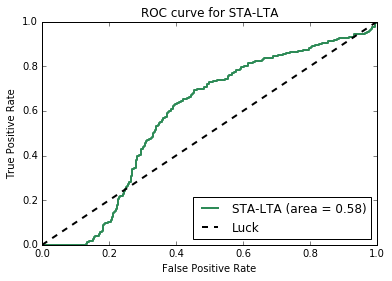

In [30]:
from sklearn.metrics import roc_curve, auc
label = np.concatenate([[1] * 192, [0] * 1343])
score = np.concatenate([data1, data0])
fpr, tpr, _ = roc_curve(label, score)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, lw=lw, color='seagreen', label='STA-LTA (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for STA-LTA')
plt.legend(loc="lower right")